In [ ]:
!wget https://raw.githubusercontent.com/ardisdataset/ARDIS//Updates-Date-String/Date%20Strings%20Part%20I.zip
!wget https://raw.githubusercontent.com/ardisdataset/ARDIS//Updates-Date-String/Date%20Strings%20Part%20II.zip
!wget https://raw.githubusercontent.com/ardisdataset/ARDIS//Updates-Date-String/Date%20Strings%20Part%20III.zip

In [ ]:
!unzip Date\ Strings\ Part\ I.zip
!mkdir Date\ Strings\ Part\ I
!mv Part\ I Date\ Strings\ Part\ I
!mv Part\ I.xlsx Date\ Strings\ Part\ I
!unzip Date\ Strings\ Part\ II.zip
!mkdir Date\ Strings\ Part\ II
!mv Part\ II Date\ Strings\ Part\ II
!mv Part\ II.xlsx Date\ Strings\ Part\ II
!unzip Date\ Strings\ Part\ III.zip
!mkdir Date\ Strings\ Part\ III
!mv Part\ III Date\ Strings\ Part\ III
!mv Part\ III.xlsx Date\ Strings\ Part\ III

In [ ]:
# Bu kitaptan alınma: https://www.amazon.com/Modern-Computer-Vision-PyTorch-applications/dp/1839213477
# Önceden büyük oranda çalışmıştım bu kitabı; ama ben kendim kesinlikle CTC loss gibi bir loss fonsiyonunu sıfırdan bulamazdım.

In [1]:
#%pip install torch_snippets torch_summary editdistance

In [1]:
from torch_snippets import *
from torchsummary import summary
import editdistance
import random
#from torch_lr_finder import LRFinder

# For reproducible results
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
dfs1 = pd.read_excel('Date Strings Part I/Part I.xlsx')
dfs2 = pd.read_excel('Date Strings Part II/Part II.xlsx')
dfs3 = pd.read_excel('Date Strings Part III/Part III.xlsx')
labels_train = {}
labels_test = {}
train_items = []
test_items = []

In [3]:
for i in range(len(dfs1)):
    if not pd.isnull(dfs1.iloc[i,:].Image_Left):
        if (str(dfs1.iloc[i,:].Date)[1] == '9' and int(str(dfs1.iloc[i,:].Date)[2]) < 2) or (str(dfs1.iloc[i,:].Date)[1] == '8'):
            labels_train[dfs1.iloc[i,:].Image_Left] = str(dfs1.iloc[i,:].Date)
            train_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Left + '.jpg')
        else:
            labels_test[dfs1.iloc[i,:].Image_Left] = str(dfs1.iloc[i,:].Date)
            test_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Left + '.jpg')
    if not pd.isnull(dfs1.iloc[i,:].Image_Right):
        if (str(dfs1.iloc[i,:].Date)[1] == '9' and int(str(dfs1.iloc[i,:].Date)[2]) < 2) or (str(dfs1.iloc[i,:].Date)[1] == '8'):
            labels_train[dfs1.iloc[i,:].Image_Right] = str(dfs1.iloc[i,:].Date)
            train_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Right + '.jpg')
        else:
            labels_test[dfs1.iloc[i,:].Image_Right] = str(dfs1.iloc[i,:].Date)
            test_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Right + '.jpg')

In [4]:
for i in range(len(dfs2)):
    if not pd.isnull(dfs2.iloc[i,:].Image_Left):
        labels_train[dfs2.iloc[i,:].Image_Left] = str(dfs2.iloc[i,:].Date)
        train_items.append('Date Strings Part II/Part II/' + dfs2.iloc[i,:].Image_Left + '.jpg')
    if not pd.isnull(dfs2.iloc[i,:].Image_Right):
        labels_train[dfs2.iloc[i,:].Image_Right] = str(dfs2.iloc[i,:].Date)
        train_items.append('Date Strings Part II/Part II/' + dfs2.iloc[i,:].Image_Right + '.jpg')

In [5]:
for i in range(len(dfs3)):
    labels_test[dfs3.iloc[i,:].Image_name] = str(dfs3.iloc[i,:].Date)
    test_items.append('Date Strings Part III/Part III/' + dfs3.iloc[i,:].Image_name + '.jpg')

In [6]:
labels_total = {**labels_train, **labels_test}
len(labels_total)

10000

In [7]:
def fname2label(fname):
    if fname[18:21] == 'III':
        return labels_total[fname[31:-4]]
    if fname[18:21] == 'II/':
        return labels_total[fname[29:-4]]
    else:
        return labels_total[fname[27:-4]]

In [8]:
vocab = '0123456789'    # Label characters, '-' will be added later
batch_size, T, V = 64, 16, len(vocab)   # Batch size, time steps, vocabulary size

In [9]:
# Yorumlar bana ait

class CustomDataset(Dataset):
    def __init__(self, items, vocab=vocab, timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)} # Index to character mapping
        self.charList.update({0: '-'})  # Add '-' to the dictionary
        self.invCharList = {v:k for k,v in self.charList.items()}   # Character to index mapping
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]  # Randomly sample a data point
    def __getitem__(self, ix):
        item = str(self.items[ix])  # Get the image file name
        image = cv2.imread(item, 0)
        label = fname2label(item)   # Get the corresponding label
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])  # Preprocess, convert to tensor, add batch dim
            label_lengths.append(len(label))                             # Get the length of the label, CTC loss will use it
            labels.append(label)
            label_vectors.append(self.str2vec(label))   # Convert index to character with proper padding
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)   # Concatenate and send images to device
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])  # Remove characters not in the vocabulary, 
                                                                        # I couldn't understand why this is necessary, to be guaranteed I think
        val = list(map(lambda x: self.invCharList[x], string))  # Convert characters to index
        """
        previous = None
        for i in range(len(val)):
            if val[i] == previous:
                val = val[:i] + [0] + val[i:]
            previous = val[i]
        """
        if pad:
            while len(val) < self.ts:   # Pad the rest of the label with 0 which means '-'
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,64)):
        target = np.ones(shape)*255 # Create a blank image
        try:    # Calculate how the image is to be resized to maintain the aspect ratio
            H, W = shape
            h, w = img.shape
            fx = H/h    # Resize factor
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img  # Paste the resized image into the blank image
        except:
            ...
        return (255-target)/255.0   # Convert the image to have a black background and normalize pixel values to be between 0 and 1
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()  # Detach from the computation graph and convert to numpy array
        for i in range(len(pred)):  # Iterate over the predicted characters
            k = np.argmax(pred[i])  # Get the character (index) that has the highest confidence
            if k > 0 and self.charList[k] != last:  # If the character is not '-' and is not the same as the last character
                last = self.charList[k] # Update the last character
                decoded = decoded + last    # Add the character to the decoded string
            elif k > 0 and self.charList[k] == last:    # If the character is not '-' and is the same as the last character
                continue    # Skip the character, because it is the same as the last character in the time step
            else:   # If the character is '-'
                last = ""   # Reset the last character with an empty string
        return decoded.replace(" "," ")
    def wer(self, preds, labels):   # Word Error Rate, 4-digit number in this case
        c = 0
        for p, l in zip(preds, labels):
            c += p.strip() != l.strip()  # Count the number of errors
        return round(c/len(preds), 4)
    def cer(self, preds, labels):   # Character Error Rate, 1-digit in this case
        c = []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))  # Fast implementation of the Levenshtein distance
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'digit-error-rate': self.cer(preds, labels),
                'whole-number-error-rate': self.wer(preds, labels),
                'digit-acc' : 1 - self.cer(preds, labels),
                'number-acc' : 1 - self.wer(preds, labels)}


In [10]:
trn_ds = CustomDataset(train_items)
val_ds = CustomDataset(test_items)

trn_dl = DataLoader(trn_ds, batch_size=batch_size, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)

In [11]:
from torch_snippets import Reshape, Permute

class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            #nn.ReLU(inplace=True),
            nn.GELU(),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [12]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock(1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 16),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.GRU(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1), # 10 classes + 1 for the '-' character
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [13]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [14]:
"""
model = Ocr(len(vocab)).to(device)
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))
"""

'\nmodel = Ocr(len(vocab)).to(device)\nfrom torchsummary import summary\nsummary(model, torch.zeros((1,1,32,128)).to(device))\n'

In [15]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [16]:
@torch.no_grad()    # No need to track the gradients
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [17]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True) # Reduce learning rate when a metric -val loss in this case- has stopped improving

n_epochs = 40
log = Report(n_epochs)  # Report object to keep track of training progress

In [65]:
"""
lr_finder = LRFinder(model, optimizer, criterion, device)   # LRFinder object to find the optimal (?) learning rate
lr_finder.range_test(trn_dl, end_lr=10, num_iter=1000)
lr_finder.plot()
schedule = torch.optim.lr_scheduler.1CycleLR(optimizer)
"""
#Didn't work as expected.

'\nlr_finder = LRFinder(model, optimizer, criterion, device)   # LRFinder object to find the optimal (?) learning rate\nlr_finder.range_test(trn_dl, end_lr=10, num_iter=1000)\nlr_finder.plot()\nschedule = torch.optim.lr_scheduler.1CycleLR(optimizer)\n'

In [66]:
for ep in range(n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['digit-acc'], results['number-acc']
        log.record(pos=pos, trn_loss=loss, trn_digit_acc=ca, trn_number_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        val_loss, results = validate_batch(data, model)
        ca, wa = results['digit-acc'], results['number-acc']
        log.record(pos=pos, val_loss=val_loss, val_digit_acc=ca, val_number_acc=wa, end='\r')
    #scheduler.step(val_loss)    # Update the learning rate based on the validation loss if the validation loss has stopped improving for more than 3 epochs
    log.report_avgs(ep+1)
    print()
    for jx in range(5): # Sample 5 random images and labels from the validation set
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 1.000	trn_loss: 1.260	trn_digit_acc: 0.559	trn_number_acc: 0.032	val_loss: 1.753	val_digit_acc: 0.588	val_number_acc: 0.044	(14.13s - 551.23s remaining)

Pred: `1902` :: Truth: `1915`
Pred: `1905` :: Truth: `1901`
Pred: `1915` :: Truth: `1944`
Pred: `1909` :: Truth: `1927`
Pred: `1905` :: Truth: `1922`

EPOCH: 2.000	trn_loss: 0.773	trn_digit_acc: 0.700	trn_number_acc: 0.162	val_loss: 1.467	val_digit_acc: 0.664	val_number_acc: 0.127	(25.72s - 488.64s remaining)

Pred: `1912` :: Truth: `1942`
Pred: `1900` :: Truth: `1906`
Pred: `1918` :: Truth: `1898`
Pred: `1909` :: Truth: `1957`
Pred: `1908` :: Truth: `1912`

EPOCH: 3.000	trn_loss: 0.544	trn_digit_acc: 0.808	trn_number_acc: 0.338	val_loss: 1.464	val_digit_acc: 0.705	val_number_acc: 0.184	(37.39s - 461.12s remaining)

Pred: `1900` :: Truth: `1948`
Pred: `1916` :: Truth: `1912`
Pred: `1903` :: Truth: `1938`
Pred: `1906` :: Truth: `1935`
Pred: `1902` :: Truth: `1903`

EPOCH: 4.000	trn_loss: 0.429	trn_digit_acc: 0.861	trn_number_acc

100%|██████████| 141/141 [00:00<00:00, 546.11it/s]


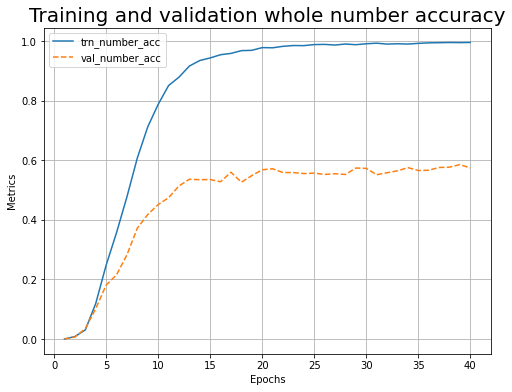

In [58]:
log.plot_epochs(['trn_number_acc','val_number_acc'], title='Training and validation whole number accuracy')
# EPOCH: 40.000	trn_loss: 0.020	trn_digit_acc: 0.999	trn_number_acc: 0.995
# val_loss: 1.606	val_digit_acc: 0.856	val_number_acc: 0.574	(485.80s - 0.00s remaining)
# LSTM

100%|██████████| 141/141 [00:00<00:00, 470.27it/s]


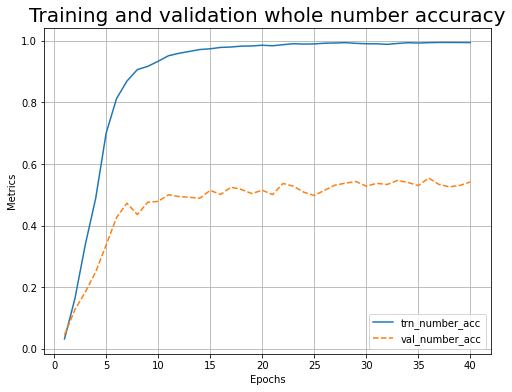

In [67]:
log.plot_epochs(['trn_number_acc','val_number_acc'], title='Training and validation whole number accuracy')
# EPOCH: 40.000	trn_loss: 0.030	trn_digit_acc: 0.999	trn_number_acc: 0.994
# val_loss: 1.821	val_digit_acc: 0.859	val_number_acc: 0.542	(473.22s - 0.00s remaining)
# GRU

In [ ]:
# 55-60 % accuracy. Test kümesinin %35 -> 1920 ve sonrası oluşturuyor. Max -> 65 %?

In [68]:
#torch.save(model.state_dict(), 'ctc_gru.pt')

In [18]:
model.load_state_dict(torch.load('ctc_gru.pt'))

<All keys matched successfully>

In [19]:
def preprocess(img_path, shape=(32,64)):
    img = cv2.imread('Date Strings Part III/Part III/' + img_path, 0)
    target = np.ones(shape)*255 # Create a blank image
    # Calculate how the image is to be resized to maintain the aspect ratio
    H, W = shape
    h, w = img.shape
    fx = H/h    # Resize factor
    fy = W/w
    f = min(fx, fy)
    _h = int(h*f)
    _w = int(w*f)
    _img = cv2.resize(img, (_w,_h))
    target[:_h,:_w] = _img  # Paste the resized image into the blank image

    return (255-target)/255.0

In [24]:
picture_file = 'v120912.b820.s78.jpg'

output = model(torch.Tensor(preprocess(picture_file)).unsqueeze(0).unsqueeze(0).to(device)).detach().cpu().numpy()

output.shape, output.argmax(axis=2)

((16, 1, 11),
 array([[ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [10],
        [10],
        [ 1],
        [ 0],
        [ 4]]))

In [23]:
picture_file = 'v120912.b820.s78.jpg'

output = model(torch.Tensor(preprocess(picture_file)).unsqueeze(0).unsqueeze(0).to(device)).argmax(2).detach().cpu().numpy()

result = []
previous = -1
for i in range(output.shape[0]):
    if output[i] == 0:
        previous = 0
        continue
    
    if output[i] != previous:
        result.append(int(output[i] - 1))
        previous = output[i]

result

[1, 9, 0, 3]

In [62]:
outputs = []

for ix, data in enumerate(val_dl):
    
    results = model(data[0])
    #labels = data[1]
    for i in range(64):
        a = []
        previous = None
        for j in results.argmax(-1).detach().cpu().numpy()[:, i]:
            if j == previous:
                continue
            if j != 0:
                a.append(j - 1)
            
            previous = j
            
        outputs.append(a)

In [63]:
labels_number = []

for ix, data in enumerate(val_dl):
    
    #results = model(data[0])
    labels = data[1]
    for i in range(64):
        labels_number.append(labels[i][:4] - 1)
#    plt.imshow(data[0][12].detach().cpu().numpy().squeeze(0))
#    if ix == 0:
#        break

In [71]:
labels_number = []

for ix, data in enumerate(trn_dl):
    
    #results = model(data[0])
    labels = data[1]
    for i in range(64):
        labels_number.append(labels[i][:4] - 1)
#    plt.imshow(data[0][12].detach().cpu().numpy().squeeze(0))
#    if ix == 0:
#        break

In [64]:
len(labels_number)

2048

In [65]:
labels[0][:4]-1

tensor([1, 8, 9, 9], device='cuda:0')

In [74]:
labels.detach().cpu().numpy()[12, :], labels_number[12]

(array([ 2, 10,  1, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([1, 9, 0, 3], device='cuda:0'))

In [66]:
second = []
third = []
fourth = []

for i in labels_number:
    second.append(i[1])
    third.append(i[2])
    fourth.append(i[3])

In [67]:
num = 0
indexes_with_length_three = []
for i in range(len(outputs)):
    if len(outputs[i]) == 3:
        num += 1
        indexes_with_length_three.append(i)
num

21

In [68]:
for i in indexes_with_length_three:
    print(outputs[i], labels_number[i])

[1, 9, 1] tensor([1, 9, 2, 3], device='cuda:0')
[1, 9, 0] tensor([1, 9, 2, 0], device='cuda:0')
[1, 9, 4] tensor([1, 9, 2, 4], device='cuda:0')
[1, 9, 4] tensor([1, 9, 2, 1], device='cuda:0')
[1, 9, 6] tensor([1, 9, 2, 6], device='cuda:0')
[1, 9, 9] tensor([1, 9, 5, 7], device='cuda:0')
[1, 9, 9] tensor([1, 9, 2, 2], device='cuda:0')
[1, 9, 2] tensor([1, 9, 3, 2], device='cuda:0')
[1, 9, 5] tensor([1, 9, 3, 5], device='cuda:0')
[1, 9, 9] tensor([1, 9, 3, 9], device='cuda:0')
[1, 9, 7] tensor([1, 9, 0, 3], device='cuda:0')
[1, 9, 6] tensor([1, 9, 0, 6], device='cuda:0')
[1, 9, 8] tensor([1, 8, 9, 8], device='cuda:0')
[1, 9, 1] tensor([1, 9, 3, 4], device='cuda:0')
[1, 9, 5] tensor([1, 9, 2, 5], device='cuda:0')
[1, 9, 8] tensor([1, 8, 9, 8], device='cuda:0')
[1, 9, 8] tensor([1, 8, 9, 8], device='cuda:0')
[1, 9, 9] tensor([1, 8, 9, 9], device='cuda:0')
[1, 9, 6] tensor([1, 9, 3, 6], device='cuda:0')
[1, 9, 7] tensor([1, 8, 9, 7], device='cuda:0')
[1, 9, 7] tensor([1, 8, 9, 7], device='c

In [72]:
second_o = []
third_o = []
fourth_o = []

for i in outputs:
    if len(i) in [2, 3]:
        continue
    second_o.append(i[1])
    third_o.append(i[2])
    fourth_o.append(i[3])

In [73]:
len(third), len(third_o)

(2048, 2026)

In [ ]:
for i in indexes_with_length_three:
    second.pop(i)

In [113]:
for i in indexes_with_length_three:
    third.pop(i)

In [114]:
for i in indexes_with_length_three:
    fourth.pop(i)

In [115]:
acc = 0

for i in range(len(second)):
    if second[i] == second_o[i]:
        acc = acc + 1
acc/len(second)

0.9735553379040157

In [ ]:
acc = 0

for i in range(len(third)):
    if third[i] == third_o[i]:
        acc = acc + 1
acc/len(third)

In [75]:
out_of_distribution = 0

for i in labels_number:
    if i[2] > 1 and i[1] == 9:
        out_of_distribution = out_of_distribution + 1
out_of_distribution/len(labels_number)

0.35107421875

In [77]:
labels_number

[tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 1], device='cuda:0'),
 tensor([1, 9, 2, 2], device='cuda:0'),
 tensor([1, 9, 2, 2], device='cuda:0'),
 tensor([1, 9, 2, 3], device='cuda:0'),
 tensor([1, 9, 2, 3], device='cuda:0'),
 tensor([1, 9, 2, 4], device='cuda:0'),
 tensor([1, 9, 2, 4], device='cuda:0'),
 tensor([1, 9, 2, 5], device='cuda:0'),
 tensor([1, 9, 2, 5], device='cuda:0'),
 tensor([1, 9, 2, 6], device='cuda:0'),
 tensor([1, 9, 2, 6], device='cuda:0'),
 tensor([1, 9, 2, 7], device='cuda:0'),
 tensor([1, 9, 2, 7], device='cuda:0'),
 tensor([1, 9, 2, 0], device='cuda:0'),


In [ ]:
acc = 0

for i in range(len(fourth)):
    if fourth[i] == fourth_o[i]:
        acc = acc + 1
acc/len(fourth)

In [79]:
labels_number[-1]

tensor([1, 8, 9, 9], device='cuda:0')

In [32]:
results.argmax(-1).detach().cpu().numpy()[:, 0]

array([ 2, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3])

In [33]:
outputs[-1], results.argmax(-1).detach().cpu().numpy()[:, -1]

([1, 9, 1, 5],
 array([ 2, 10, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6]))

In [41]:
print(results.argmax(-1).detach().cpu().numpy()[:, 0])
print(labels.detach().cpu().numpy()[0, :])

[ 2  9 10 10  0  0  0  0  0  0  0  0  0  0  0 10]
[ 2 10  3  1  0  0  0  0  0  0  0  0  0  0  0  0]


tensor([ 2, 10,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')

In [ ]:
y_pred = model(val_ds)

In [ ]:
confusion_matrix(val_ds.cpu().detach().numpy(), y_pred, labels=[8,9])